# Model Analysis

We'll explore the results from the models generated in `modeling.ipynb` here.

Let's start with our imports & reading in our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (precision_score, recall_score,
                             precision_recall_curve,f1_score, 
                             fbeta_score, confusion_matrix)


from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)


In [2]:
# read in pickled feature DF generated by feature_engineering_3.ipynb
X = pd.read_pickle("./pickle/X_F.pickle")

In [3]:
X['streak_abs'] = X.streak_abs.fillna(0)
X_train, X_test, y_train, y_test = split_users(X, subset=False, test_size=0.2)


    X_train sample size: 6782401
    X_test sample size: 1692260


In [4]:
with open(f"models/xgboost_fit_fillna.pickle", "rb") as pfile:
        xgb_fit = pickle.load(pfile)

In [5]:
with open(f"models/rf_fit.pickle", "rb") as pfile:
        rf_fit = pickle.load(pfile)

In [6]:
X_train, X_test, y_train, y_test = split_users(X, subset=False, test_size=0.2)


    X_train sample size: 6782401
    X_test sample size: 1692260


In [37]:
X.shape

(8474661, 29)

In [7]:
X.columns

Index(['product_id', 'user_id', 'user_total_prod_orders', 'cart', 'in_cart',
       'last_cart', 'in_last_cart', 'qty_reordered', 'qty_sold',
       'prod_reorder_pct', 'prod_prior_sales', 'prod_pct_reorders',
       'prod_avg_atco', 'user_avg_cart_size', 'days_since_prior_order',
       'order_hour_of_day', 'user_avg_spacing', 'streak_nan', 'up_buy_streak',
       'up_n5_n_buys', 'up_n5_buy_ratio', 'up_atco_sum', 'up_atco_avg',
       'prod_total_mkt_share', 'prod_total_mkt_share_log', 'aisle_total_sales',
       'prod_aisle_mkt_share', 'prod_aisle_mkt_share_log', 'streak_abs'],
      dtype='object')

In [8]:
rf_fit.score(X_test, y_test)

0.9091812132887381

In [9]:
xgb_fit.score(X_test, y_test)

0.9098129129093638

In [10]:
def make_confusion_matrix(model, threshold=0.5, title=None):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    
    confusion = confusion_matrix(y_test, y_predict)
    
    fig, ax = plt.subplots(dpi=80, figsize=(6, 6))
    
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
    labels = [f"{v2}\n\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    label_font = {'family': 'Lato',
        'color':  'orange',
        'weight': 'bold',
        'size': 23,
        }
    
    title_font = {'family': 'Lato',
        'color':  'orange',
        'weight': 'bold',
        'size': 27,
        }
    
    sns.set(font_scale=1.6)
    # good cmaps: RdYlBu, coolwarm, RdBu
    # oranges (to fit ppt theme): YlOrBr, YlOrRd, OrRd, Oranges, autumn, tab10, prism
    sns.heatmap(confusion, annot=labels, fmt="", cmap="prism", cbar=False,
               xticklabels=['no_reorder', 'reorder'],
               yticklabels=['no_reorder', 'reorder'])
    
    if title == None:
        title = "Confusion Matrix"
    plt.title(title, fontdict=label_font)
    plt.xlabel('Prediction', fontdict=label_font)
    plt.ylabel('Actual', fontdict=label_font)


# Determining the Optimal Probability Threshold

What will Instacart use this model for?

This is an important question to consider at every stage, especially when determining our probability threshold. We can adjust the threshold meter in the below confusion matrix to determine the optimal probability threshold our model uses to classify inputs. A higher threshold means the model will be less likely to classify an input as a 'reorder'. A lower threshold results in more `1` predictions. If our model were a person, the person would *need less convincing* to predict `1` with a *lower threshold*.

**So...what does that mean for our Instacart dataset?**

Instacart uses the model's predictions for two use-cases (per their [blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)):
1. "Buy it Again?" user prompts
2. "Frequently bought with..." user prompt when shopping


In both cases, the 'risk' of making false reorder predictions seems pretty low (if any). In practice, this means to prioritize **recall** (`predicted positives / all positives`) & reduce false negatives as much as possible. We'll intentionally be inflating our false positives (incorrectly predicting an item as a reorder in the user's next cart). Doing this should benefit Instacart, as highlighting these items to the user may increase conversion.

In summary, **our goal is find a low enough probability threshold in which items that the user *might* purchase are captured, while still correctly classifying products the user is very unlikely to purchase.** In practice, this means that we'll be using the F-2 measure to calculate the optimal threshold for recall. F-1 is the most common metric for this, but F-2 will better for prioritizing recall. F-1 is a 'balanced' measure of precision vs. recall.

As a reminder:
* **Precision** = TruePositives / (TruePositives + FalsePositives)
* **Recall** = TruePositives / (TruePositives + FalseNegatives)

Let's try and find a reasonable probability threshold using the below slider & confusion matrix.

In [11]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(xgb_fit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [12]:
threshold = 0.14

y_predict = (xgb_fit.predict_proba(X_test)[:, 1] >= threshold)

confusion = confusion_matrix(y_test, y_predict)

Optimal threshold based on playing with slider in above confusion matrix: 0.14

So what's our new precision and F1 metrics, using this threshold?

**Precision = TruePositives / (TruePositives + FalsePositives)**

**Recall = TruePositives / (TruePositives + FalseNegatives)**

In [13]:
confusion

array([[1264396,  262509],
       [  56191,  109164]])

In [14]:
true_pos = confusion[1][1]
true_neg = confusion[0][0]

false_pos = confusion[0][1]
false_neg = confusion[1][0]

true_pos, true_neg, false_pos, false_neg

(109164, 1264396, 262509, 56191)

In [15]:
precision = true_pos / (true_pos + false_pos)

precision

0.2937097932860337

In [16]:
recall = true_pos / (true_pos + false_neg)

recall

0.660179613558707

And now...our adjusted F-1 score

F-1 = (2 * Precision * Recall) / (Precision + Recall)

In [17]:
f1 = (2 * precision * recall) / (precision + recall)

f1

0.40654863433563987

In [18]:
type(xgb_fit)

xgboost.sklearn.XGBClassifier

In [19]:
def get_threshold_scores(model, X_test, y_test, min_threshold=0.01, max_threshold=1.0, beta=2):
    """
        Returns 4 threshold:metric mappers for four metrics:
            - f1_thresholds
            - f2_thresholds
            - f2_precision_thresholds
            - f2_recall_thresholds
    """
    
    f1_thresholds = {}
    f2_thresholds = {}
    f2_precision_thresholds = {}
    f2_recall_thresholds = {}
    
    for threshold in np.arange(min_threshold, max_threshold, 0.01):
        t = round(threshold, 2)
        
        # create confusion matrix
        preds = (model.predict_proba(X_test)[:, 1] >= t)
        confusion = confusion_matrix(y_test, preds)
        
        # extract values needed for precision/recall/f-1 calculations
        true_pos = confusion[1][1]
        false_pos = confusion[0][1]
        false_neg = confusion[1][0]
        
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f_1 = (2 * precision * recall) / (precision + recall)
        f_beta = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
        f1_thresholds[threshold] = f_1
        f2_thresholds[threshold] = f_beta
        f2_precision_thresholds[threshold] = precision
        f2_recall_thresholds[threshold] = recall
        
        
        print(f"End calculating {t*100}%. F-1 score: {f_1:.6f} | F-2 score: {f_beta:.6f}")
    
    return f1_thresholds, f2_thresholds, f2_precision_thresholds, f2_recall_thresholds

In [20]:
# UNCOMMENT OUT YOUR FIRST TIME RUNNING THIS NOTEBOOK
# THEN RE-COMMENT AND USE pickle.load BELOW

# THE BELOW CODE TAKES 5-10 MINUTES TO RUN ON MY VM. UNCOMMENT IT OUT TO RUN THE FIRST TIME, THEN 
# LOAD FROM PICKLE


# f1_thresholds, f2_thresholds, f2_precision_thresholds, f2_recall_thresholds = (get_threshold_scores(
#                                     xgb_fit, X_test, y_test, min_threshold=0.01, max_threshold=0.99))



# with open("pickle/f1_thresholds.pickle", "wb") as p:
#     pickle.dump(f1_thresholds, p)
    
# with open("pickle/f2_thresholds.pickle", "wb") as p:
#     pickle.dump(f2_thresholds, p) 
    
# with open("pickle/f2_precision_thresholds.pickle", "wb") as p:
#     pickle.dump(f2_precision_thresholds, p)
    
# with open("pickle/f2_recall_thresholds.pickle", "wb") as p:
#     pickle.dump(f2_recall_thresholds, p) 

End calculating 1.0%. F-1 score: 0.178029 | F-2 score: 0.351269
End calculating 2.0%. F-1 score: 0.179655 | F-2 score: 0.353761
End calculating 3.0%. F-1 score: 0.205752 | F-2 score: 0.391310
End calculating 4.0%. F-1 score: 0.240917 | F-2 score: 0.435902
End calculating 5.0%. F-1 score: 0.266447 | F-2 score: 0.463931
End calculating 6.0%. F-1 score: 0.288629 | F-2 score: 0.484783
End calculating 7.000000000000001%. F-1 score: 0.310849 | F-2 score: 0.502583
End calculating 8.0%. F-1 score: 0.330049 | F-2 score: 0.515034
End calculating 9.0%. F-1 score: 0.346286 | F-2 score: 0.523125
End calculating 10.0%. F-1 score: 0.361029 | F-2 score: 0.528527
End calculating 11.0%. F-1 score: 0.374879 | F-2 score: 0.531413
End calculating 12.0%. F-1 score: 0.386419 | F-2 score: 0.531990
End calculating 13.0%. F-1 score: 0.396884 | F-2 score: 0.530980
End calculating 14.000000000000002%. F-1 score: 0.406549 | F-2 score: 0.528336
End calculating 15.0%. F-1 score: 0.414740 | F-2 score: 0.524159
End ca

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 87.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 88.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 89.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 90.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 91.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 92.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 93.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 94.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 95.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 96.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 97.0%. F-1 score: nan | F-2 score: nan
End calculating 98.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


In [21]:
# rf_f1_thresholds, rf_f2_thresholds, rf_f2_precision_thresholds, rf_f2_recall_thresholds = (get_threshold_scores(
#                                     rf_fit, X_test, y_test, min_threshold=0.01, max_threshold=0.99))

# with open("pickle/rf_f1_thresholds.pickle", "wb") as p:
#     pickle.dump(rf_f1_thresholds, p)
    
# with open("pickle/rf_f2_thresholds.pickle", "wb") as p:
#     pickle.dump(rf_f2_thresholds, p) 
    
# with open("pickle/rf_f2_precision_thresholds.pickle", "wb") as p:
#     pickle.dump(rf_f2_precision_thresholds, p)
    
# with open("pickle/rf_f2_recall_thresholds.pickle", "wb") as p:
#     pickle.dump(rf_f2_recall_thresholds, p) 

End calculating 1.0%. F-1 score: 0.181280 | F-2 score: 0.356230
End calculating 2.0%. F-1 score: 0.214752 | F-2 score: 0.403162
End calculating 3.0%. F-1 score: 0.246610 | F-2 score: 0.442223
End calculating 4.0%. F-1 score: 0.269561 | F-2 score: 0.466529
End calculating 5.0%. F-1 score: 0.288297 | F-2 score: 0.483763
End calculating 6.0%. F-1 score: 0.309734 | F-2 score: 0.500650
End calculating 7.000000000000001%. F-1 score: 0.329476 | F-2 score: 0.513072
End calculating 8.0%. F-1 score: 0.347492 | F-2 score: 0.521875
End calculating 9.0%. F-1 score: 0.362212 | F-2 score: 0.526867
End calculating 10.0%. F-1 score: 0.376680 | F-2 score: 0.529195
End calculating 11.0%. F-1 score: 0.388654 | F-2 score: 0.528584
End calculating 12.0%. F-1 score: 0.398747 | F-2 score: 0.526368
End calculating 13.0%. F-1 score: 0.405606 | F-2 score: 0.523088
End calculating 14.000000000000002%. F-1 score: 0.410815 | F-2 score: 0.520586
End calculating 15.0%. F-1 score: 0.416023 | F-2 score: 0.517244
End ca

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 85.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 86.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 87.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 88.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 89.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 90.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 91.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 92.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 93.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 94.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 95.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 96.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 97.0%. F-1 score: nan | F-2 score: nan
End calculating 98.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
# load in thresholds

with open("pickle/f1_thresholds.pickle", "rb") as p:
    f1_thresholds = pickle.load(p)
    
with open("pickle/f2_thresholds.pickle", "rb") as p:
    f2_thresholds = pickle.load(p) 
    
with open("pickle/f2_precision_thresholds.pickle", "rb") as p:
    f2_precision_thresholds = pickle.load(p)
    
with open("pickle/f2_recall_thresholds.pickle", "rb") as p:
    f2_recall_thresholds = pickle.load(p) 
    
with open("pickle/rf_f1_thresholds.pickle", "rb") as p:
    rf_f1_thresholds = pickle.load(p)
    
with open("pickle/rf_f2_thresholds.pickle", "rb") as p:
    rf_f2_thresholds = pickle.load(p) 
    
with open("pickle/rf_f2_precision_thresholds.pickle", "rb") as p:
    rf_f2_precision_thresholds = pickle.load(p)
    
with open("pickle/rf_f2_recall_thresholds.pickle", "rb") as p:
    rf_f2_recall_thresholds = pickle.load(p) 

In [23]:
#setup threshold plot
X_thresholds = f1_thresholds.keys()
y_f1 = f1_thresholds.values()
y_f2 = f2_thresholds.values()

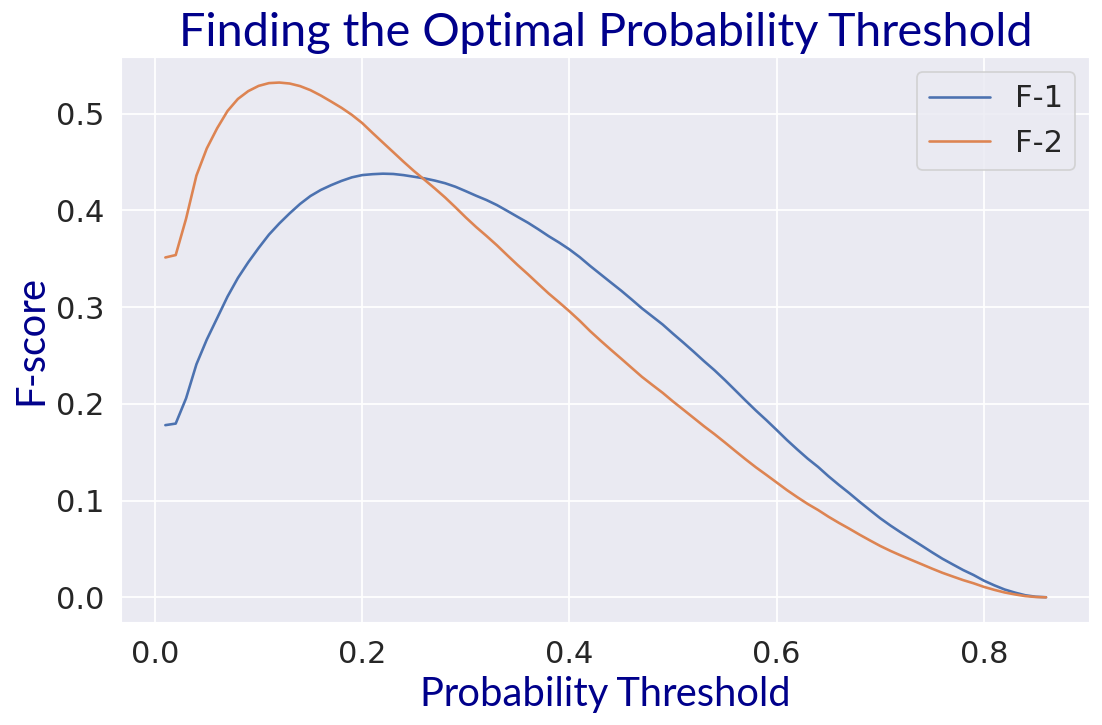

In [24]:
plt.figure(figsize=(10, 6), facecolor='white', dpi=125)

label_font = {'family': 'Lato',
    'color':  'darkblue',
    'weight': 'normal',
    'size': 23,
    }

title_font = {'family': 'Lato',
    'color':  'darkblue',
    'weight': 'normal',
    'size': 27,
    }

plt.plot(X_thresholds, y_f1)
plt.plot(X_thresholds, y_f2)
plt.title("Finding the Optimal Probability Threshold", fontdict=title_font)
plt.xlabel("Probability Threshold", fontdict=label_font)
plt.ylabel("F-score", fontdict=label_font)
plt.legend(["F-1", "F-2"])
# ax.grid(color='black', linestyle='-', linewidth=0.7)

# ax.set_facecolor("white")

In [25]:
def pull_optimal_fs(f1_thresholds, f2_thresholds):
    """
    Parameters
    _____
    f2_thresholds(dict, required): Mapping, like {probability_threshold: f2_score}
    
    Returns:
    _____
    String containing the threshold parameter resulting in the highest F-2 score.
    """
    # pull the threshold with the highest f-1 score
    max_f1 = (0, 0)
    max_f2 = (0, 0)
    
    for thresh, f1 in f1_thresholds.items():    
        if f1 > max_f1[1]:
            max_f1 = thresh, f1
        continue

    for thresh, f2 in f2_thresholds.items():
        if f2 > max_f2[1]:
            max_f2 = thresh, f2
        continue
    
    return max_f1, max_f2
        
        
max_f1, max_f2 = pull_optimal_fs(f1_thresholds, f2_thresholds)

In [26]:
max_f1, max_f2

((0.22, 0.43784245795386645), (0.12, 0.5319898591824849))

## Now we have our optimal threshold (in terms of F2).

Details:
* Threshold: `0.12`
* Resulting F-2 score: `0.532034`

**Let's take a look at how our new predictions look using this probability threshold.**


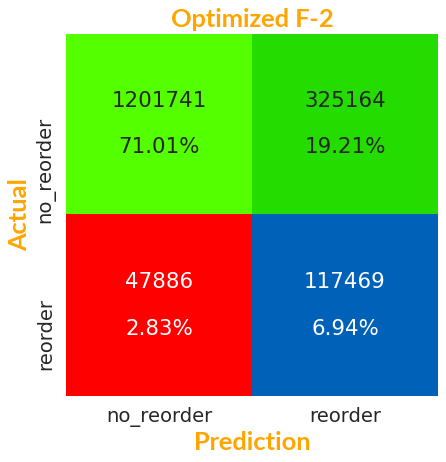

In [27]:
make_confusion_matrix(xgb_fit, threshold=0.12, title='Optimized F-2')

In [28]:
# make_confusion_matrix(xgb_fit, threshold=0.22, title='Optimized F-1')

In [29]:
optimal_threshold = 0.12

In [30]:
preds = xgb_fit.predict(X_test)

In [31]:
preds_praba = xgb_fit.predict_proba(X_test)[:, 1] >= optimal_threshold

In [32]:
f1_score(y_test, preds)

0.2724828631627118

In [33]:
precision_score(y_test, preds)

0.6433250050644879

In [34]:
recall_score(y_test, preds)

0.17284630038402227

# Precision/Recall

In [35]:
#setup precision/recall graph

no_skill = len(y_test[y_test==1]) / len(y_test)

recall = list(f2_recall_thresholds.values())
precision = list(f2_precision_thresholds.values())
rf_recall = list(rf_f2_recall_thresholds.values())
rf_precision = list(rf_f2_precision_thresholds.values())

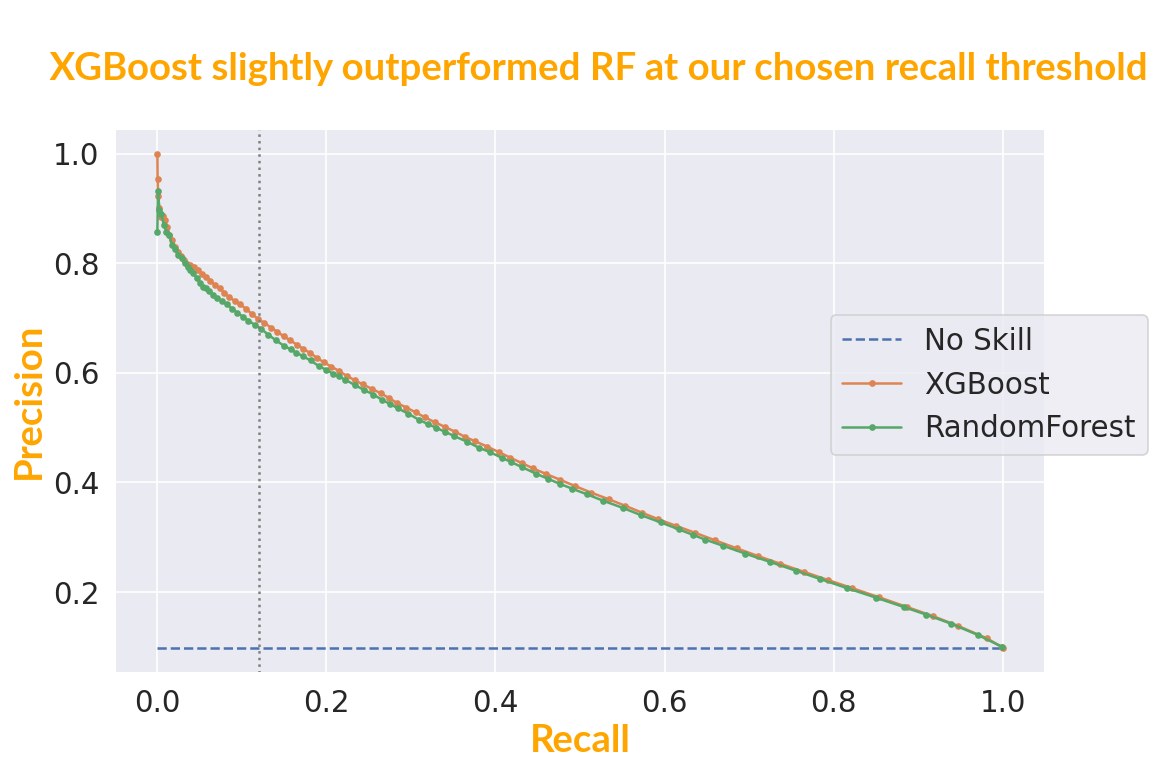

In [54]:
label_font = {'family': 'Lato',
    'color':  'orange',
    'weight': 'bold',
    'size': 23,
    }

title_font = {'family': 'Lato',
    'color':  'orange',
    'weight': 'bold',
    'size': 27,
    }

title = """
    XGBoost slightly outperformed RF at our chosen recall threshold
    """

ax = plt.figure(figsize=(10, 6), dpi=120)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label="No Skill")
plt.plot(recall, precision, marker='.', label="XGBoost")
plt.plot(rf_recall, rf_precision, marker='.', label="RandomForest")
plt.axvline(x=0.12, ls=':', color='gray')

plt.title(title, fontdict=label_font)
plt.xlabel("Recall", fontdict=label_font)
plt.ylabel("Precision", fontdict=label_font)
ax.legend(loc='center right')